In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Retail%20Transaction%20Data/Retail_Data_Transactions.csv", parse_dates=["trans_date"])

In [3]:
df.head(3)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52


In [4]:
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [6]:
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


In [7]:
sd = dt.datetime(2015,4,1)
df['hist']=sd - df['trans_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head()

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,779.0
1,CS4768,2015-03-15,39,17.0
2,CS2122,2013-02-26,52,764.0
3,CS1217,2011-11-16,99,1232.0
4,CS1850,2013-11-20,78,497.0


In [8]:
df=df[df['hist'] < 730]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63633 entries, 1 to 124999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  63633 non-null  object        
 1   trans_date   63633 non-null  datetime64[ns]
 2   tran_amount  63633 non-null  int64         
 3   hist         63633 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
rfmTable = df.groupby('customer_id').agg({'hist': lambda x:x.min(),                    
                                        'customer_id': lambda x: len(x),             
                                        'tran_amount': lambda x: x.sum()})            

In [10]:
rfmTable.head()

,hist,customer_id,tran_amount
customer_id,,,
CS1112,77.0,6,358
CS1113,51.0,11,775
CS1114,48.0,11,804
CS1115,27.0,10,765
CS1116,219.0,5,333


In [11]:
rfmTable.rename(columns={'hist': 'recency', 'customer_id': 'frequency', 'tran_amount': 'monetary_value'}, inplace=True)

In [12]:
rfmTable.head()

,recency,frequency,monetary_value
customer_id,,,
CS1112,77.0,6,358
CS1113,51.0,11,775
CS1114,48.0,11,804
CS1115,27.0,10,765
CS1116,219.0,5,333


In [13]:
df[df["customer_id"]=="CS1112"]

,customer_id,trans_date,tran_amount,hist
5650,CS1112,2015-01-14,39,77.0
17810,CS1112,2014-07-16,90,259.0
26626,CS1112,2014-04-29,63,337.0
31500,CS1112,2014-12-04,59,118.0
42084,CS1112,2013-07-01,36,639.0
74842,CS1112,2013-11-13,71,504.0


In [14]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      recency  frequency  monetary_value
0.25     38.0        7.0           379.0
0.50     69.0        9.0           591.0
0.75    127.0       11.0           796.0 <class 'pandas.core.frame.DataFrame'>


In [15]:
quartiles=quartiles.to_dict()
quartiles

{'recency': {0.25: 38.0, 0.5: 69.0, 0.75: 127.0},
 'frequency': {0.25: 7.0, 0.5: 9.0, 0.75: 11.0},
 'monetary_value': {0.25: 379.0, 0.5: 591.0, 0.75: 796.0}}

In [16]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4    
    
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
customer_id,,,,,,
CS1112,77.0,6,358,2,1,1
CS1113,51.0,11,775,3,3,3
CS1114,48.0,11,804,3,3,4
CS1115,27.0,10,765,4,3,3
CS1116,219.0,5,333,1,1,1


In [17]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS1112,77.0,6,358,2,1,1,211
CS1113,51.0,11,775,3,3,3,333
CS1114,48.0,11,804,3,3,4,334
CS1115,27.0,10,765,4,3,3,433
CS1116,219.0,5,333,1,1,1,111


In [18]:
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS8892,190.0,7,379,1,1,1,111
CS4119,134.0,6,378,1,1,1,111
CS5496,183.0,6,378,1,1,1,111
CS8522,269.0,7,377,1,1,1,111
CS5080,300.0,6,375,1,1,1,111
...,...,...,...,...,...,...,...
CS2659,33.0,12,804,4,4,4,444
CS5848,20.0,12,803,4,4,4,444
CS1944,33.0,12,802,4,4,4,444


In [19]:
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()

RFMClass
111     230.907975
112     461.333333
113     609.500000
121     324.096154
122     513.865169
123     652.716312
124     816.500000
131     350.000000
132     479.200000
133     712.770115
134     831.971429
142     501.500000
143     746.937500
144     960.285714
211     247.666667
212     465.619318
213     605.000000
221     326.098039
222     512.409524
223     655.697368
231     335.000000
232     489.859375
233     711.404255
234     834.352113
242     528.923077
243     738.615385
244     982.434174
311     258.209559
312     464.374150
313     616.600000
321     332.772727
322     509.475904
323     661.487013
331     346.000000
332     477.266667
333     706.114173
334     853.373134
342     523.285714
343     739.839286
344     993.914489
411     267.688312
412     466.422078
413     601.250000
421     317.112903
422     508.502890
423     651.675000
431     365.000000
432     490.388889
433     713.430712
434     843.608696
442     521.812500
443     740.833333
444

In [20]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6884 entries, CS1112 to CS9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6884 non-null   float64
 1   frequency       6884 non-null   int64  
 2   monetary_value  6884 non-null   int64  
 3   R_Quartile      6884 non-null   int64  
 4   F_Quartile      6884 non-null   int64  
 5   M_Quartile      6884 non-null   int64  
 6   RFMClass        6884 non-null   object 
 7   Total Score     6884 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 484.0+ KB
             recency  frequency  monetary_value  R_Quartile  F_Quartile  \
customer_id                                                               
CS1112          77.0          6             358           2           1   
CS1113          51.0         11             775           3           3   
CS1114          48.0         11             804           3           3   
CS1

In [21]:
rfmTable.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
customer_id,,,,,,,,
CS1112,77.0,6,358,2,1,1,211,4
CS1113,51.0,11,775,3,3,3,333,9
CS1114,48.0,11,804,3,3,4,334,10
CS1115,27.0,10,765,4,3,3,433,10
CS1116,219.0,5,333,1,1,1,111,3


In [22]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean()

Total Score
3      230.907975
4      335.414443
5      385.731672
6      447.638221
7      557.809645
8      629.974101
9      741.711462
10     849.503277
11     952.057621
12    1001.289963
Name: monetary_value, dtype: float64

<AxesSubplot:xlabel='Total Score'>

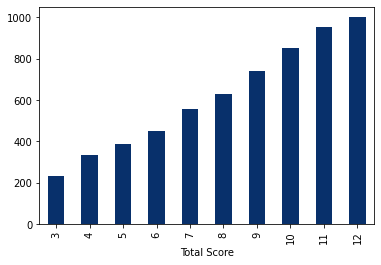

In [23]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

<AxesSubplot:xlabel='Total Score'>

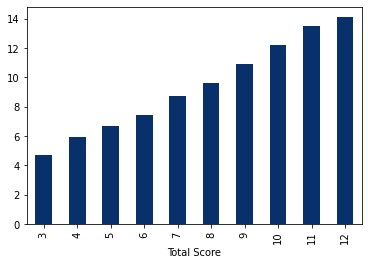

In [24]:
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

<AxesSubplot:xlabel='Total Score'>

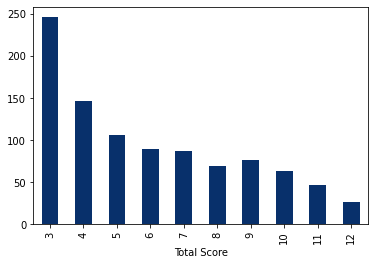

In [25]:
rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')

In [26]:
res = pd.read_csv('https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Retail%20Transaction%20Data/Retail_Data_Response.csv')
res.sort_values('customer_id', inplace=True)

print(res.head(), res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB
  customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1 None


In [27]:
rfmSeg.reset_index(inplace=True)
rfmSeg.head()

,customer_id,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
0,CS1112,77.0,6,358,2,1,1,211,4
1,CS1113,51.0,11,775,3,3,3,333,9
2,CS1114,48.0,11,804,3,3,4,334,10
3,CS1115,27.0,10,765,4,3,3,433,10
4,CS1116,219.0,5,333,1,1,1,111,3


In [28]:
rfmSeg.sort_values('customer_id', inplace=True)
rfm2=pd.merge(rfmSeg, res, on='customer_id')
rfm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6884 entries, 0 to 6883
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     6884 non-null   object 
 1   recency         6884 non-null   float64
 2   frequency       6884 non-null   int64  
 3   monetary_value  6884 non-null   int64  
 4   R_Quartile      6884 non-null   int64  
 5   F_Quartile      6884 non-null   int64  
 6   M_Quartile      6884 non-null   int64  
 7   RFMClass        6884 non-null   object 
 8   Total Score     6884 non-null   int64  
 9   response        6884 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 591.6+ KB


Text(0, 0.5, 'Proportion of Responders')

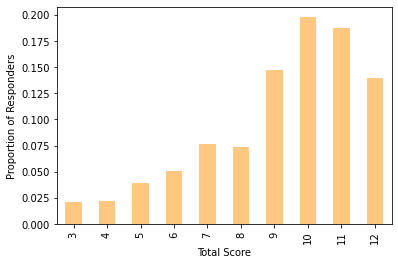

In [29]:
ax=rfm2.groupby('Total Score').agg('response').mean().plot(kind='bar', colormap='copper_r')
ax.set_xlabel("Total Score")
ax.set_ylabel("Proportion of Responders")